# Introduction to Spark Streaming

_____
### Note on  Streaming
Streaming is something that is rapidly advancing and changin fast, there are multiple new libraries every year, new and different services always popping up, and what is in this notebook may or may not apply to you. Realistically speaking each situation is going to require a customized solution and there is not a one size fits all solution. Because of this, I wanted to point out some great resources for Python and Spark Streaming:

* [The Official Documentation is great. This should be your first go to.](http://spark.apache.org/docs/latest/streaming-programming-guide.html#spark-streaming-programming-guide)

* [Fantastic Guide to Spark Streaming with Kafka](https://www.rittmanmead.com/blog/2017/01/getting-started-with-spark-streaming-with-python-and-kafka/)

* [Another Spark Streaming Example with Geo Plotting](http://nbviewer.jupyter.org/github/ibm-cds-labs/spark.samples/blob/master/notebook/DashDB%20Twitter%20Car%202015%20Python%20Notebook.ipynb)
____

### Prerequisites. Obtain Twitter API Credentials
In order to use all of this though, we need to setup a Developer API acocunt with Twitter and create an application to get credentials. 

- make sure you have a twitter account
- set up a Developer API account with Twitter
- create an application to get credentials at [https://apps.twitter.com/](https://apps.twitter.com/)
    + Consumer Key 
    + Consumer Secret 
    + Access Token
    + Access Token Secret


### Step 1. First let us install python **tweepy** package
- this will be used by the tweetread.py

Please run the following first to ensure the course VM is temporarily connected to outside world (for installing tweepy).

In [ ]:
!export http_proxy="http://proxy.oit.umn.edu:3128"
!export https_proxy="https://proxy.oit.umn.edu:3128"

Then run the tweepy installation

In [ ]:
! pip install tweepy

## Step 2: Configure tweetread.py
by copying and pasting the following from your Twitter API console
+ Consumer Key 
+ Consumer Secret 
+ Access Token
+ Access Token Secret

### Step 2: Run tweetread.py at a terminal using
```bash
python tweetread.py
``` 
It will pause after saying "Listening on port: 5555". 
It will start receiving tweeter stream only after it accepts a connection on port 5555.


### Step 4. Verify spark context and sqlContext

In [1]:
# May cause deprecation warnings, safe to ignore, they aren't errors
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

In [21]:
sc

<SparkContext master=local[*] appName=PySparkShell>

The following ensures that we don't end up using multiple SQL context for different microbatches. Instead, we should maintain a single sqlContext instance for the given spark context

In [47]:
def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']

In [57]:
get_sql_context_instance(sc)

### Step 5. create streaming context and listen to socket 5555

In [49]:
ssc = StreamingContext(sc, 1)  # set to 10 second batching interval

In [50]:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555) 

### Step 6. specify the sliding window for the Dstream

- making the new window size 10 seconds and sliding interval 2 seconds

In [51]:
lines = socket_stream.window(30, 1) 

### Step 6. Convert DStream RDDs into Hive temp tables

- extract all hashtags from the tweet text
- do a word count on hashtags
- convert the result into a DataFrame
- register the dataframe, sorted by count, as a temp table

In [ ]:
# define customer output action, which creates a temp view called tweets
def process_rdd(rdd):
    sql_context = get_sql_context_instance(rdd.context)
    df = sql_context.createDataFrame(rdd)
    df.sort("count", ascending=False).limit(10).createOrReplaceTempView("tweets") # Registers to a table.
    
# Use Parenthesis for multiple lines or use 
    
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # retain only hash tags
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduce to get hashtag count
  .map( lambda r: Row(tag=r[0], count=r[1] ) ) # Stores in a Tweet Object
  .foreachRDD(process_rdd) # Registers to a table.
)

### Step 7. Start the DStream 
- after this, you can no longer add more DStream operations. 

In [53]:
ssc.start()    

In [54]:
get_sql_context_instance(sc).sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |   tweets|       true|
+--------+---------+-----------+



### Step 8. The driver monitors the temp table and visualize it

we are using one simple technique of drawing a live figure in jupyter notebook
https://github.com/anujgupta82/Musings/blob/master/Dynamic%20or%20Live%20update%20of%20a%20Plot.ipynb


<IPython.core.display.Javascript object>


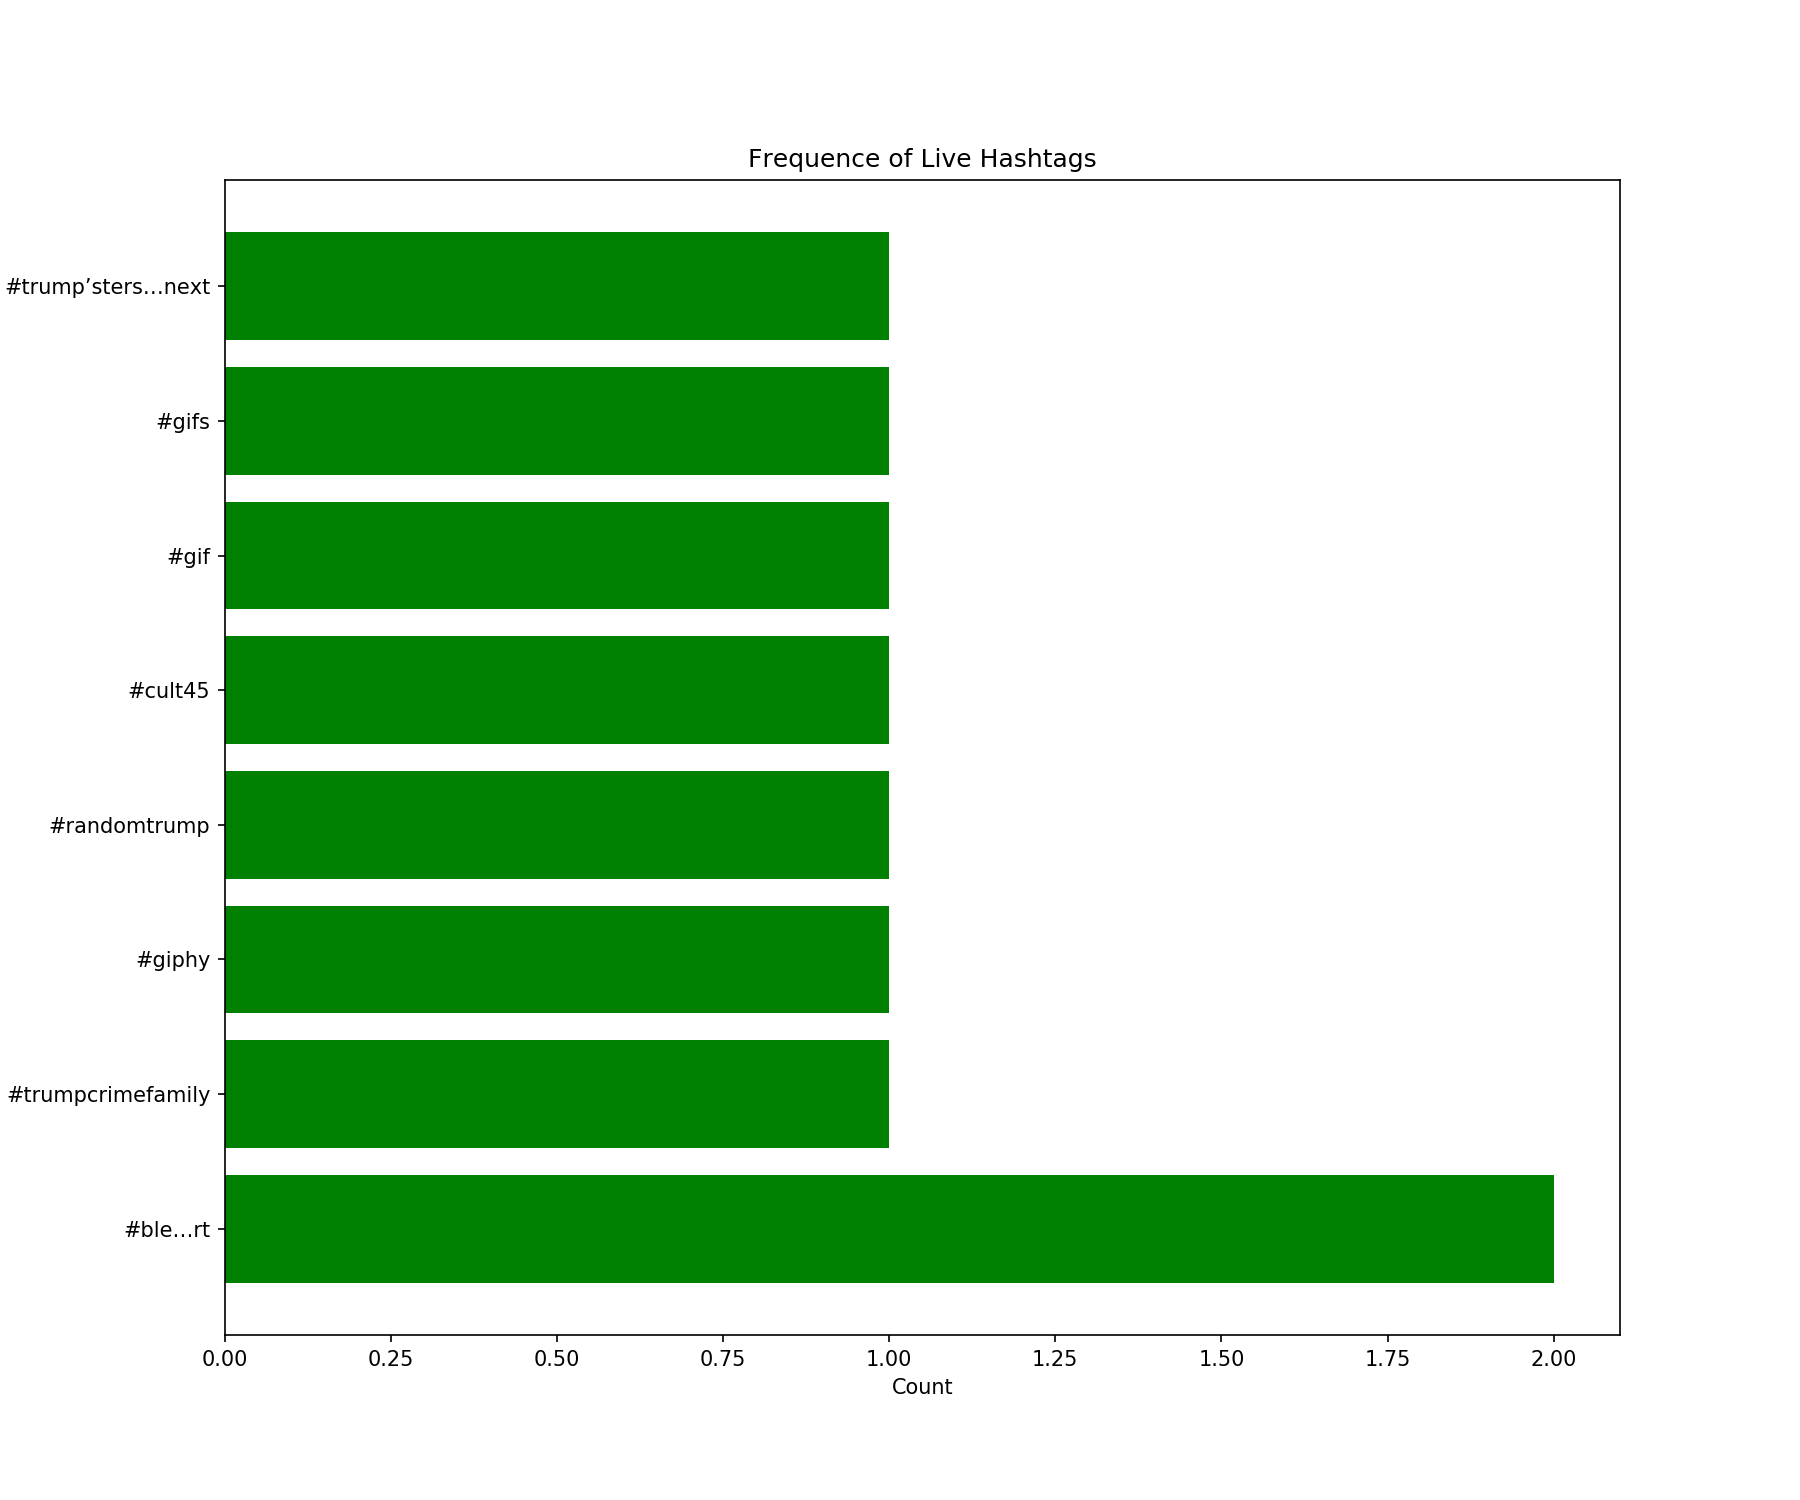

In [55]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time

fig = plt.figure(figsize=(12,10))  # specify figure size in inches
ax = fig.add_subplot(111)  # 1x1 grid
plt.ion()  # turn on interacgive mode

fig.show()
fig.canvas.draw()

for i in range(0,10):  # update 10 times then stop
    ax.clear()  
    # obtain the top 10 tags from tmp table and conver to pandas DF.
    df_top_tags = get_sql_context_instance(sc).sql( 'Select tag, count from tweets order by count desc limit 10' ).toPandas()
    y_pos = np.arange(df_top_tags.shape[0])
    ax.barh(y_pos, df_top_tags['count'], align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_top_tags['tag'])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Count')
    ax.set_title('Frequence of Live Hashtags')
    fig.canvas.draw()
    time.sleep(1)  # sleep one 1 second

### Step 9:  stop the spark streaming process 
- stop the streaming context but not the spark kernel

In [59]:
ssc.stop(False)

### Step 10: stop the tweetread.py gracefully

**pkill -f** allows you to kill a process by the command you used.

In [60]:
!pkill -f 'python tweetread.py'